In [3]:
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal as signal
from scipy.interpolate import make_lsq_spline, BSpline
from scipy.interpolate import make_interp_spline
from scipy.interpolate import splrep

import test_data as td
if td.DATA is None:
    td.set_test_data(
    data_size=5000, 
    start_time=datetime.datetime(2023, 3, 21, 12, 24).timestamp(),
    moving_av=False
    )


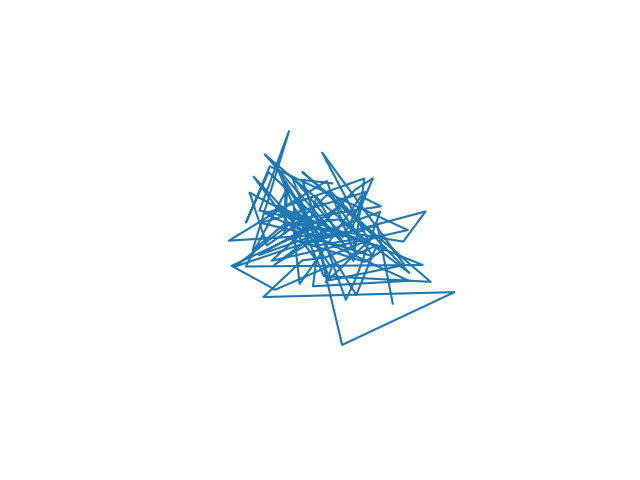

In [10]:
%matplotlib widget

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create data
x = np.random.standard_normal(100)
y = np.random.standard_normal(100)
z = np.random.standard_normal(100)

plt.axis('off')
ax.plot3D(x, y, z) 

plt.show()

In [5]:
import core as co
import piecewise_fit as ls

Test data size is 10002
Test data start time is 2023:01:02 22:58
Test data end time is   2023:01:09 21:39
Subtracting moving avarage: True


In [6]:
shift = 0
length = 1200
limits = (0 + shift, length + shift)

value = td.VALUE[limits[0]: limits[1]]
cndl_count = np.arange(*limits, dtype='float64')

savgol_filter = co.Savgol_filter(window=50, order=3)
filtered_savgol = savgol_filter.filter(value)

np.set_printoptions(formatter={'float_kind':"{:-.3e}".format})

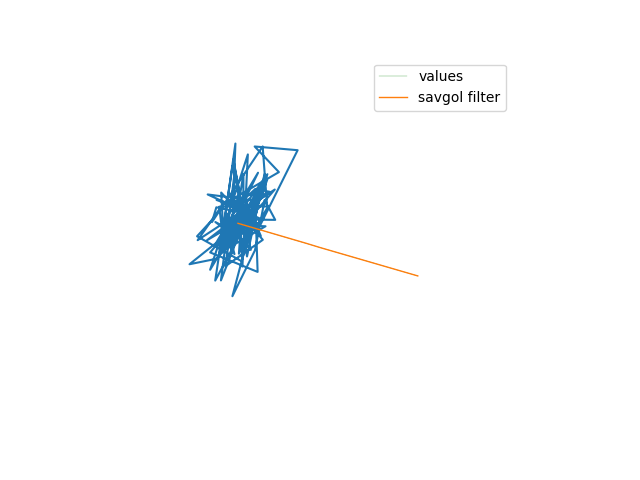

In [7]:
plt.plot(cndl_count, value, label='values', color='green', linewidth=0.2)
plt.plot(cndl_count, filtered_savgol, label='savgol filter', linewidth=1)

plt.legend()
plt.show()

In [8]:
def power_spectrum(values, freq=0, filter=False):
    if values is None:
        return None, None, None
    ps = np.abs(np.fft.fft(values))**2
    freqs = np.fft.fftfreq(len(values), d=1)
    idx = np.argsort(freqs)
    freqencies = freqs[idx]
    log_powers = [math.log10(p) for p in ps[idx]] 
    log_powers_filtered = signal.savgol_filter(log_powers, 100, 2)
    for i in range(len(freqencies)):
        if freqencies[i] > - math.fabs(freq):
            log_power = log_powers_filtered[i]
            break

    if filter:
        log_powers = log_powers_filtered
    return freqencies, log_powers, 10 ** log_power

# freqencies, log_powers, power = power_spectrum(value, freq=0.3, filter=True)
# if freqencies is not None:
#     print(f'{power:1.1e}')
#     plt.plot(freqencies, log_powers, label='values')

# freqencies, log_powers, power = power_spectrum(filtered, freq=0.3, filter=False)
# if freqencies is not None:
#     print(f'{power:1.1e}')
#     plt.plot(freqencies, log_powers, label='filtered')

In [9]:
NUMDER_PIECES = 10
WINDOW = 250
K = 1
SCALE_X = 1.e-6

def piecewise(
        shift=0, window=WINDOW, filter=co.Savgol_filter(window=50, order=2),
        scale_x=SCALE_X, number_pieces=NUMDER_PIECES, k=K):
    value = td.VALUE[shift: window + shift]
    if filter is not None:
        value = filter.filter(value)
    cndl_count = np.arange(0, len(value))
    piecewise = ls.LeastSq(ls.Splines(
        x=cndl_count, y=value, scale_x=scale_x, number_pieces=number_pieces, k=k) )
    piecewise.run()
    return piecewise.func_class, cndl_count, value

clazz, cndl_count, value = piecewise(shift=0, number_pieces=5, k=1)

plt.plot(cndl_count, value, color='green', label='data', linewidth='0.5')
plt.plot(cndl_count, clazz.approx(cndl_count), color='blue', label='approx')
plt.scatter(*clazz.knots(), color='orange', label='param final')



plt.legend()
plt.show()

ValueError: s must be a scalar, or float array-like with the same size as x and y

In [ ]:
for n in [5, 10, 15]:
    clazz, cndl_count, value = piecewise(number_pieces=n, shift=2000)
    variance = sum(clazz.func() ** 2)
    print(variance)
    plt.plot(cndl_count, clazz.approx(cndl_count), label=f'approx {n}')

plt.plot(cndl_count, value, label='data', linewidth='0.5')
plt.legend()
plt.show()

## Czy tokenizacja jest stabilna.

Ustalamy doświadczalnie okres czasu przeszłego stanowiący context decyzji: tokeny z tego okresu zasilają procesor AI. Nie chcemy żeby ten ciąg tokenów zmieniał się nie tylko przez przesunięcie końców - ewoluował wewnętrz tego okresu obserwacji.

Widzieliśmy już przypadek takiej niestabilności: gdy rysowaliśmy zęby piły na wykresie. Ta niestabilność wynika z lokalności metody określania końców tokenów. Tak samo ograniczanie w miejscach relatywnej 'stabilizacji' prowadzi do niestabilności bo dwa podobne miejsca na wykresie mogą być inaczej tokenizowane przy infinizymalnej różnicy 'stabilizacji'.


In [ ]:
for shift in [0, 10, 50, 100, 300]:
    clazz, cndl_count, value = piecewise(shift=shift)
    plt.plot(cndl_count+shift, clazz.approx(cndl_count), label=f'shift {shift}')

plt.legend()
plt.show()

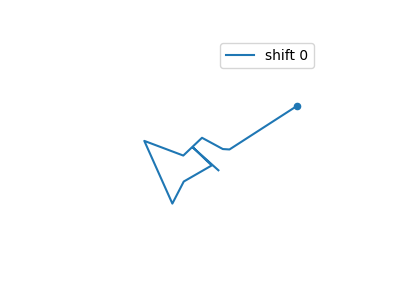

In [11]:
%matplotlib widget

def image3d(clazz):
    xk = clazz.knots()[0] * SCALE_X
    yk = clazz.knots()[1]    
    knots = []
    prev = [xk[0], yk[0]]
    for i in range(1, len(xk)):
        next = [xk[i], yk[i]]
        knot = [prev, next]
        knots.append(knot)
        prev = next

    # knors_red = []
    # for i in range(len(knots)):
    #     offset = knots[i][1][0]
    #     knors_red.append(
    #         [knots[i][0][0] - offset, knots[i][0][1]], 
    #         [knots[i][1][0] - offset, knots[i][1][1]])

    p3d = []
    for i in range(len(knots)):
        offset = knots[i][0][0]
        p3d.append(np.array([knots[i][0][1], knots[i][1][0] - offset, knots[i][1][1]]))

    return np.column_stack(p3d), p3d[-1]

sto = []
for shift in [0]:
    clazz, cndl_count, value = piecewise(shift=shift)
    sto.append((clazz, cndl_count, value, shift))

fig = plt.figure(figsize=(4, 3))
ax = plt.axes(projection='3d')
for clazz, cndl_count, value, shift in sto:
    xyz, curr = image3d(clazz)
    ax.plot3D (*xyz, label=f'shift {shift}')
    ax.scatter3D (*curr)

plt.axis('off')
# plt.axis([-0.005, 0.005, -0.005, 0.005, -0.005, 0.005])
plt.legend()
plt.show()

# for clazz, cndl_count, value, shift in sto:
#     xk = (clazz.knots()[0] - clazz.knots()[0][-1])
#     yk = clazz.knots()[1]   
#     knots = []
#     prev = [xk[0], yk[0]]
#     for i in range(1, len(xk)):
#         next = [xk[i], yk[i]]
#         knot = [prev, next]
#         knots.append(knot)
#         prev = next
        
#     plt.plot(xk, yk, label=f'shift {shift}')

# plt.legend()
# plt.show()

In [ ]:
import plotly.graph_objs as go # type: ignore
import plotly.offline as py # type: ignore

clazz, cndl_count, value = piecewise(shift=0)
xyz, curr = image3d(clazz)

fig = go.Figure(data=go.Scatter3d(
    x=xyz[0], y=xyz[1], z=xyz[2],
    marker=dict(
        size=0,
        color=z,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
))

fig.update_layout(
    width=600,
    height=600,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=0,
                y=1.0707,
                z=1,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig.show()

In [ ]:
hist_data = [values[1][0] for values in all_data]
plt.hist(hist_data, bins=100, edgecolor='black', density=True)
plt.show()

sin_data = [math.sin(math.pi * n * 0.01) for n in range(5000)]
plt.hist(sin_data, bins=100, edgecolor='black', density=True)
plt.show()